In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
import tensorflow_hub as hub
import tokenization1
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv("/content/FINAL_DATA2.csv")
df.cleanData=df.cleanData.astype(str)
df.dtypes

twitter_id             int64
content               object
location              object
search_word            int64
word_length            int64
cleanData             object
location_extracted    object
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.cleanData,df.search_word, test_size = 0.2, stratify = df.search_word,random_state = 42)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization1.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=171):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=171):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
import keras
max_len = 171
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
train_labels = y_train

In [ ]:
import tensorflow as tf
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 171)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 171)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 171)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 171, 768)]                'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max',save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=8, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_data=(test_input,y_test),
    epochs=60,
    callbacks=[checkpoint, earlystopping],
    batch_size=30,verbose=1)

Epoch 1/60
66/66 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.8146
Epoch 00001: val_accuracy improved from -inf to 0.90467, saving model to model.h5
66/66 [==============================] - 138s 2s/step - loss: 0.5090 - accuracy: 0.8146 - val_loss: 0.2687 - val_accuracy: 0.9047
Epoch 2/60
66/66 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9345
Epoch 00002: val_accuracy improved from 0.90467 to 0.92495, saving model to model.h5
66/66 [==============================] - 137s 2s/step - loss: 0.2054 - accuracy: 0.9345 - val_loss: 0.1974 - val_accuracy: 0.9249
Epoch 3/60
66/66 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9543
Epoch 00003: val_accuracy improved from 0.92495 to 0.94929, saving model to model.h5
66/66 [==============================] - 137s 2s/step - loss: 0.1306 - accuracy: 0.9543 - val_loss: 0.1615 - val_accuracy: 0.9493
Epoch 4/60
66/66 [==============================] - ETA: 0s - loss: 0.0822 -

In [ ]:
model.evaluate(test_input,y_test) 

16/16 [==============================] - 11s 669ms/step - loss: 0.3308 - accuracy: 0.9473


[0.3307691216468811, 0.9472616910934448]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

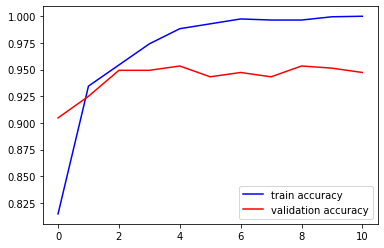

In [ ]:
plt.plot(train_history.history['accuracy'],c='b',label='train accuracy')
plt.plot(train_history.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

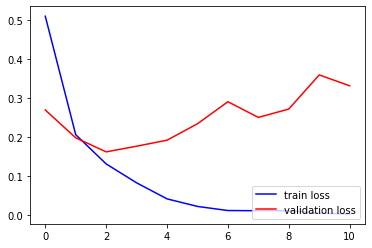

In [ ]:
plt.plot(train_history.history['loss'],c='b',label='train loss')
plt.plot(train_history.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X_new=["There is an accident in the area , 3 got dead on site and others are injured heavily"]
new_input = bert_encode(X_new, tokenizer, max_len=max_len)

In [ ]:
pred=model.predict(new_input)
pred

array([[0.9613284 , 0.03411213, 0.00455958]], dtype=float32)

In [ ]:
import numpy as np
labels = ['Accident','Traffic','Potholes']
print(labels[np.argmax(pred)])

Accident


In [ ]:
from sklearn.metrics import classification_report

y_pred=model.predict(test_input)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)


              precision    recall  f1-score   support

           0       0.87      0.79      0.83        66
           1       0.96      0.98      0.97       418
           2       1.00      0.44      0.62         9

    accuracy                           0.95       493
   macro avg       0.94      0.74      0.80       493
weighted avg       0.95      0.95      0.94       493

